In [1]:
!ls -la .

total 12
drwxr-xr-x 2 root root 4096 Jul 10 14:22 .
drwxr-xr-x 5 root root 4096 Jul 10 14:22 ..
---------- 1 root root  263 Jul 10 14:22 __notebook_source__.ipynb


In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/output'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!git clone https://github.com/OnlpLab/Hebrew-Sentiment-Data.git

Cloning into 'Hebrew-Sentiment-Data'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (64/64), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 64 (delta 33), reused 27 (delta 15), pack-reused 0
Unpacking objects: 100% (64/64), done.


In [4]:
!pip install transformers

In [5]:
from transformers import BertModel, BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('onlplab/alephbert-base')
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("onlplab/alephbert-base", num_labels=5)
model.save_pretrained("./initial_pretrained")

Downloading:   0%|          | 0.00/545k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/288 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/565 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/504M [00:00<?, ?B/s]

Some weights of the model checkpoint at onlplab/alephbert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at onlplab/alephbert-base

In [6]:
!ls -latr ./initial_pretrained

total 492208
drwxr-xr-x 4 root root      4096 Jul 10 14:24 ..
-rw-r--r-- 1 root root       854 Jul 10 14:24 config.json
drwxr-xr-x 2 root root      4096 Jul 10 14:24 .
-rw-r--r-- 1 root root 504008201 Jul 10 14:24 pytorch_model.bin


In [7]:
import pandas as pd
dataset = {
            "name": "Heb Poems",
            "train_path": "../input/poetry/train.csv",
            "dev_path": "../input/poetry/validation.csv",
            "test_path": "../input/poetry/test.csv",
            'classes': ['0','1', '2', '3', '4']
          }

def read_data():
    train = pd.read_csv(dataset['train_path'])
    dev = pd.read_csv(dataset['dev_path'])
    test = pd.read_csv(dataset['test_path'])
    return train, dev, test
train, dev, test = read_data()
train_encodings = tokenizer(train["content"].to_list(), truncation=True, padding=True)
dev_encodings = tokenizer(dev["content"].to_list(), truncation=True, padding=True)
test_encodings = tokenizer(test["content"].to_list(), truncation=True, padding=True)
train_labels=train["birth"].to_list()
dev_labels=dev["birth"].to_list()
test_labels=test["birth"].to_list()

import torch

class HebrewPoemsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = HebrewPoemsDataset(train_encodings, train_labels)
dev_dataset = HebrewPoemsDataset(dev_encodings, dev_labels)
test_dataset = HebrewPoemsDataset(test_encodings, test_labels)

In [8]:
!pip install wandb

In [9]:
from transformers import Trainer,TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    per_device_eval_batch_size=64,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset             # evaluation dataset
)

trainer.train()
trainer.save_model("./alephbert_sentiment")

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.10.33 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Step,Training Loss
10,1.728300
20,1.618300
30,1.429600
40,1.211000
50,1.143400
60,1.000400
70,0.846400
80,0.674800
90,0.603000
100,0.538100


In [10]:
!ls -latr ./alephbert_sentiment/

total 492216
drwxr-xr-x 8 root root      4096 Jul 10 14:40 ..
-rw-r--r-- 1 root root       854 Jul 10 14:40 config.json
-rw-r--r-- 1 root root 504011017 Jul 10 14:40 pytorch_model.bin
drwxr-xr-x 2 root root      4096 Jul 10 14:40 .
-rw-r--r-- 1 root root      2351 Jul 10 14:40 training_args.bin


In [11]:
import numpy as np

In [12]:
raw_pred, _, _ = trainer.predict(test_dataset)

# Preprocess raw predictions
y_pred = np.argmax(raw_pred, axis=1)

In [13]:
y_pred

array([2, 1, 3, ..., 3, 1, 1])

In [14]:
count_equals=0
for a,b in zip(test_dataset.labels, y_pred):
    if a==b:
        count_equals+=1
print(f"accuracy={count_equals/len(y_pred)}")

accuracy=0.9294566253574833


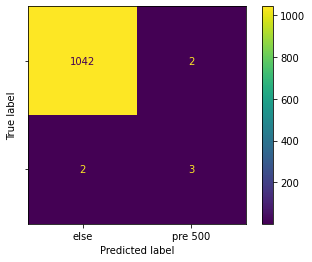

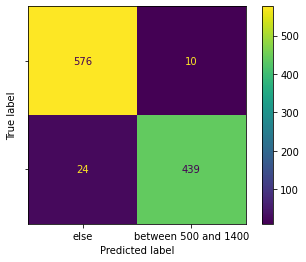

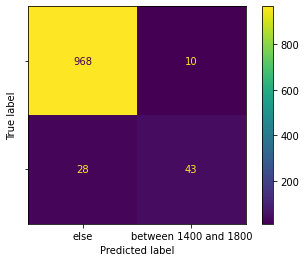

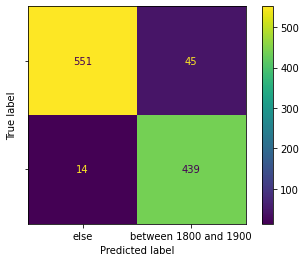

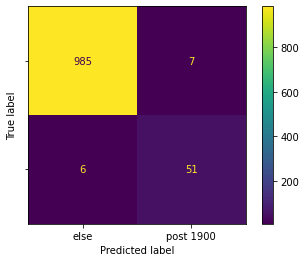

In [45]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

eras_dict = {0 : ("pre 500", "else"),1 : ("between 500 and 1400", "else"), 2: ("between 1400 and 1800", "else"), 3 : ("between 1800 and 1900", "else"), 4: ("post 1900", "else")}

mats = multilabel_confusion_matrix(test_dataset.labels, y_pred)
for i in range(len(mats)):
    ls = reversed(list(eras_dict[i]))
    disp = ConfusionMatrixDisplay(confusion_matrix=mats[i], display_labels=ls)
    disp.plot()
    plt.savefig(f"birth {eras_dict[i][0]}")

In [46]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns


def plot_multiclass_roc(y_test, y_score, n_classes, figsize=(17, 6)):
    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    for i in range(n_classes):
        binarize = np.vectorize(lambda x : 1 if x == i else 0)
        fpr[i], tpr[i], _ = roc_curve(binarize(y_test), binarize(y_score))
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(n_classes):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.savefig("birth roc curve")
    plt.show()

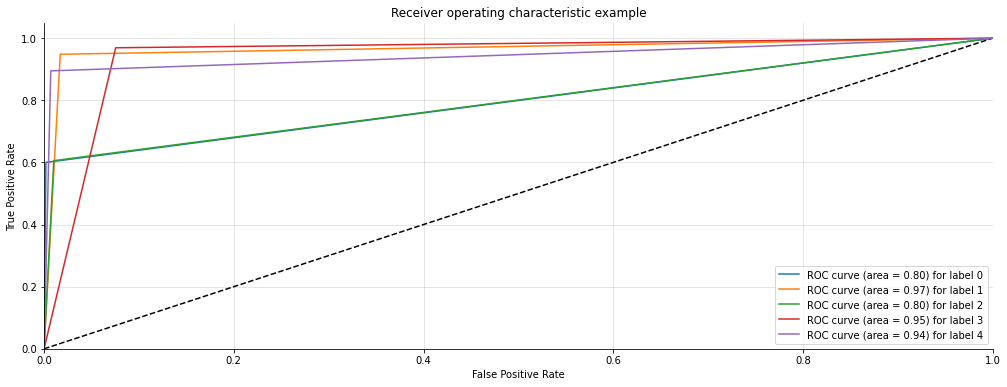

In [47]:
from sklearn import metrics
plot_multiclass_roc(test_dataset.labels, y_pred, 5)


In [39]:
from sklearn.metrics import precision_recall_fscore_support

precision_recall_fscore_support(test_dataset.labels, y_pred)

(array([0.6       , 0.97772829, 0.81132075, 0.90702479, 0.87931034]),
 array([0.6       , 0.94816415, 0.6056338 , 0.96909492, 0.89473684]),
 array([0.6       , 0.9627193 , 0.69354839, 0.93703308, 0.88695652]),
 array([  5, 463,  71, 453,  57]))

In [43]:
npa = np.asarray(test_dataset.labels)
np.savetxt("birth_lables.csv", npa, delimiter=",")
np.savetxt("birth_predictions.csv", y_pred, delimiter=",")


